In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()



True

In [3]:
os.getenv("Alpha_API_Key")

'FIEFKAQGL5FPPCVC'

In [20]:
ALPHA_VANTAGE_API_KEY = os.getenv('premium_alpha_api_key')
BASE_URL = 'https://www.alphavantage.co/query'


In [21]:
symbol = 'YOUR_STOCK_SYMBOL'

url = f'{BASE_URL}?function=TIME_SERIES_ANNUAL&symbol={symbol}&apikey={ALPHA_VANTAGE_API_KEY}'
response = requests.get(url)
data = response.json()

In [22]:
# Function to retreive stock data

def get_stock_data(symbol):
    function = 'TIME_SERIES_DAILY'
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': ALPHA_VANTAGE_API_KEY,
        'outputsize': 'full'
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code != 200:
        print(f'Error fetching data for {symbol}: {response.status_code}')
        return None
    data = response.json()
    if "Error Message" in data:
        print(f'Error for symbol {symbol}: {data["Error Message"]}')
        return None
    return data

In [23]:
def process_daily_data(data):
    """Convert the daily stock data into a Pandas DataFrame."""
    if 'Time Series (Daily)' not in data:
        print('Unexpected response structure:', data)
        return None
    
    time_series = data['Time Series (Daily)']
    daily_data = pd.DataFrame.from_dict(time_series, orient='index')
    daily_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    daily_data.index = pd.to_datetime(daily_data.index)  # Convert index to datetime
    daily_data = daily_data.astype(float)  # Convert data types to float
    daily_data.sort_index(inplace=True)  # Sort by date
    return daily_data

In [24]:
get_stock_data("PLTR") # Test: Having a look at Palantir. 

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'PLTR',
  '3. Last Refreshed': '2024-11-22',
  '4. Output Size': 'Full size',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2024-11-22': {'1. open': '61.6000',
   '2. high': '64.4400',
   '3. low': '61.3700',
   '4. close': '64.3500',
   '5. volume': '61381713'},
  '2024-11-21': {'1. open': '62.0400',
   '2. high': '63.4000',
   '3. low': '60.8950',
   '4. close': '61.3600',
   '5. volume': '56336740'},
  '2024-11-20': {'1. open': '62.5900',
   '2. high': '63.0800',
   '3. low': '59.9600',
   '4. close': '62.1200',
   '5. volume': '59182183'},
  '2024-11-19': {'1. open': '59.5100',
   '2. high': '63.0100',
   '3. low': '59.2650',
   '4. close': '62.9800',
   '5. volume': '75557817'},
  '2024-11-18': {'1. open': '64.9200',
   '2. high': '64.9200',
   '3. low': '58.8500',
   '4. close': '61.2600',
   '5. volume': '137877641'},
  '2024-11-15': {'1. open': '61.0100',
   '2. hig

In [15]:
# Parsing stock data. 

def parse_stock_data(data):
    time_series = data.get('Time Series (Daily)', {})
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.astype(float)
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    return df

In [16]:
PLTR = get_stock_data("PLTR") # Test: Parsing data for Palantir.
PLTR_parsed = parse_stock_data(PLTR)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements

In [40]:
PLTR_parsed

,Open,High,Low,Close,Volume
2024-11-20,62.59,63.08,59.960,62.12,59182183.0
2024-11-19,59.51,63.01,59.265,62.98,75557817.0
2024-11-18,64.92,64.92,58.850,61.26,137877641.0
2024-11-15,61.01,66.00,60.910,65.77,155280388.0
2024-11-14,61.05,61.17,58.530,59.18,59968240.0
...,...,...,...,...,...
2020-10-06,9.04,10.18,8.900,9.90,90864039.0
2020-10-05,9.43,9.49,8.920,9.03,36316878.0
2020-10-02,9.06,9.28,8.940,9.20,55018343.0
2020-10-01,9.69,10.10,9.230,9.46,124297587.0


In [29]:
def generate_weekly_report(df):
    # Resampling to weekly frequency
    weekly_df = df.resample('W').mean()
    return weekly_df

In [49]:
def plot_weekly_report(weekly_df, symbol):
    plt.figure(figsize=(12, 6))
    
    # Plot only the Weekly Close Price
    plt.plot(weekly_df.index, weekly_df['Close'], label='Weekly Close Price', color='blue', linewidth=2)

    # Title and labels
    plt.title(f'Weekly Stock Prices for {symbol}', fontsize=16)
    plt.xlabel('Week', fontsize=14)
    plt.ylabel('Price ($)', fontsize=14)
    plt.legend()

    # Format the y-axis as dollars
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

    # Grid and styling
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the graph as an image file (optional)
    plt.savefig(f'{symbol}_weekly_report.png')
    plt.show()


In [41]:
def main(symbol):
    # Fetch and parse stock data
    data = get_stock_data(symbol)
    if data is None:
        return
    
    stock_df = parse_stock_data(data)

    # Save daily stock data to CSV
    stock_df.to_csv(f'{symbol}_daily_data.csv')

    # Generate weekly report
    weekly_report = generate_weekly_report(stock_df)
    
    # Save weekly report to CSV
    weekly_report.to_csv(f'{symbol}_weekly_report.csv')

    # Visualizations
    plot_weekly_report(weekly_report, symbol)

    print(f'Daily and weekly reports for {symbol} generated and visualized successfully!')

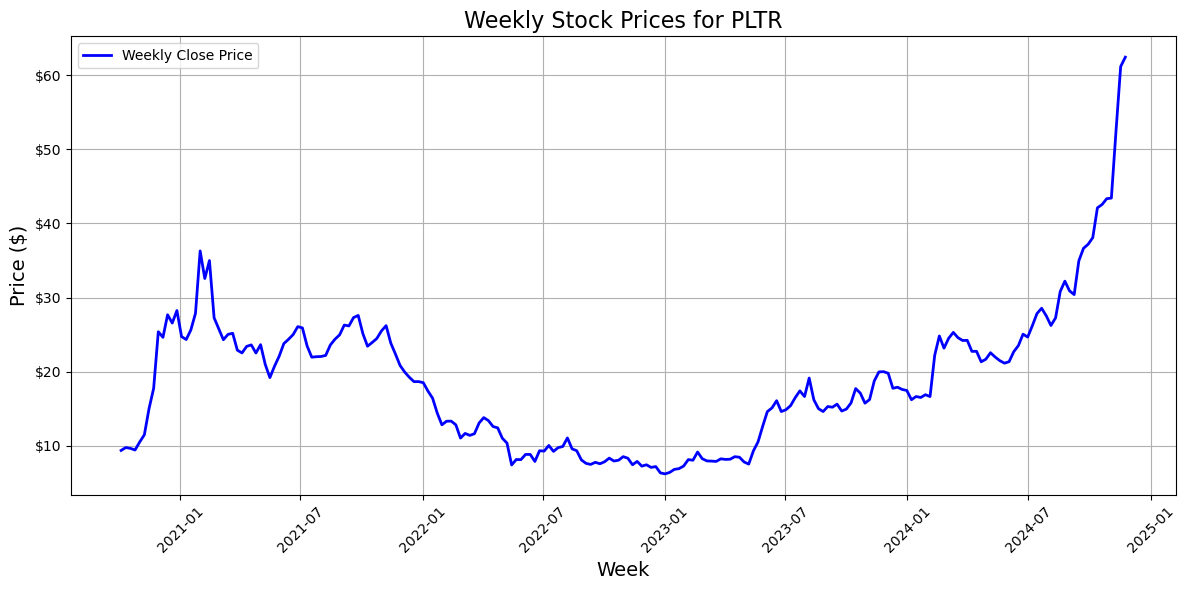

Daily and weekly reports for PLTR generated and visualized successfully!


In [50]:
main("PLTR")